## 실습 목표


1. 직접 ResNet 구현하기

2. 모델을 config에 따라서 변경 가능하도록 만들기

3. 직접 실험해서 성능 비교하기



---

## 학습내용

1. Ablation Study

2. CIFAR-10 데이터셋 준비

3. 블록 구성

4.  VGG Complete Model

5. VGG-16 vs VGG-19

6. ResNet Ablation Study

---


### Ablation Study

딥러닝 논문은 여러 방법을 통해서 문제 해결 방식을 제시하고, 이 방식들은 실효성을 증명되기 위해서는 제거한 모델 시험과 제시한 방식으로 추가한 모델 실험 결과를 비교합니다.

Ablation Study는 이처럼 아이디어 제거를 통해서 제안한 방법이 주는 성능이나 효과를 확인하는 실험을 뜻합니다.

즉, ResNet논문에서 제시한 residual connection이 Ablation Study입니다. 왜냐하면 이미지넷 검증 데이터셋에 대한 Top-1 error rate 지료를 통해 residual connection이 있는 것과 없는 plain network를 비교했고 이 비교를 통해서 성능 향상을 증명했기 때문입니다.

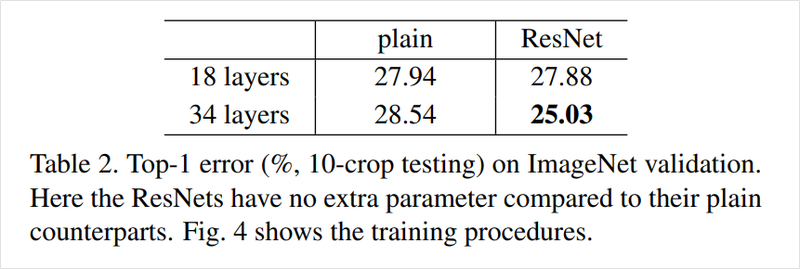


## Ablation Study 실습

실험 결과들이 실제로 유효함을 갖는지 실제 실습을 해보도록 하겠습니다. 실습 이기에 동일 데이터가 아닌 적당한 크기의 CIFAR-10 dataset을 이용하겠습니다.


우리의 실험 목적은 CIFAR-10 일반 네트워크와 ResNet구현을 하고 이 둘을 비교해서 ResNet 및 residual connection의 유효성 확인하는 것이고, 저번 블로그에 논문 정리와 구현을 했기에 코드 이해가 이전보다 잘 될 겁니다.

실습의 진행을 편하게 하도록 코드 주석처리 와 중간 중간에 용어나 진행설명 후 코드를 진행했습니다.

### CIFAR-10 데이터 준비

이 데이터셋은 10개의 카테고리이고 6만 장의 이미지가 있고 32x32픽셀입니다. 이 데이터셋을 사용하면 물체의 종류 를 분류할 수 있습니다. 

6만 장이라는 꽤 많은 데이터를 로드하려면 긴 시간이 걸리니 맘의 여유를 갖고 임하세요.

데이터 셋이 준비가 되면 클래스의 수와 이름을 볼 수 있습니다.

In [1]:
# Tensorflow datasets패키지가 없을 시 설치하기

! pip install tensorflow-datasets

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [3]:
# Tensorflow가 활용할 GPU가 장착되어 있는지 확인해 봅니다.
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

#### Flow

1. Tensorflow 설치

2. 필요한 라이브러리 불러오기

3. GPU확인

In [4]:
# 데이터 로드
import urllib3
urllib3.disable_warnings()

#tfds.disable_progress_bar()   # 이 주석을 풀면 데이터셋 다운로드과정의 프로그레스바가 나타나지 않습니다.

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
) # tfds.load(): 기본적으로 ~/tensorflow_datases 경로 데이터셋을 다운로드하고 혹시 데이터셋 경로를 바꾸고 싶다면, data_dir인자 사용하기

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling cifar10-train.tfrecord...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test examples...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Shuffling cifar10-test.tfrecord...:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /aiffel/tensorflow_datasets/cifar10/3.0.2. Subsequent calls will reuse this data.


In [5]:
# Tensorflow 데이터셋을 로드하면 꼭 feature 정보를 확인해 보세요. 
print(ds_info.features)

FeaturesDict({
    'id': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(32, 32, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})


In [6]:
# 데이터의 개수도 확인해 봅시다. 
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(50000, shape=(), dtype=int64)
tf.Tensor(10000, shape=(), dtype=int64)


### Flow

1. 데이터 다운로드

2. 데이터 특성 정보 파악

3. 훈련과 테스트 데이터 개수 파악

#### Input Normalization

이미지는 픽셀의 수를 사용하여 이미지 크기를 알 수 있고 픽셀이 가진 채널 값을 통해서 픽셀의 색을 표현하기도 합니다. 이렇게 다양한 것이 다 들어오면 모델은 혼란을 느낄 수 있기에 우리는 먼저 입력 데이터 정규화를 합니다.

정규화는 채널별 최대값이 255로 해주어서 이미지의 표현이 0과1사이로 들어오도록 합니다.


In [7]:
def normalize_and_resize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    # image = tf.image.resize(image, [32, 32])
    return tf.cast(image, tf.float32) / 255., label

In [8]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [9]:
#클래스 개수

ds_info.features["label"].num_classes

10

In [10]:
# 클래스 종류
ds_info.features["label"].names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

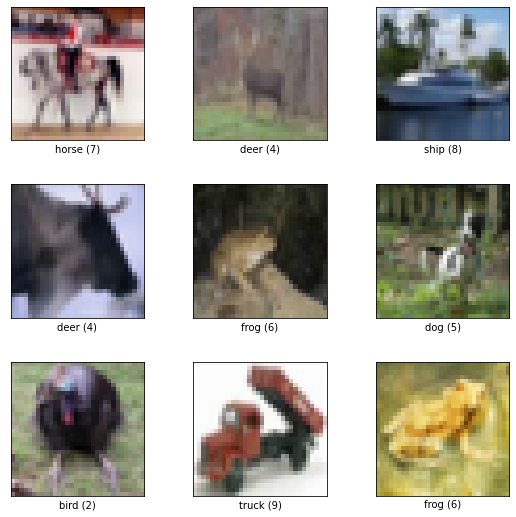

In [11]:
fig = tfds.show_examples(ds_train, ds_info)

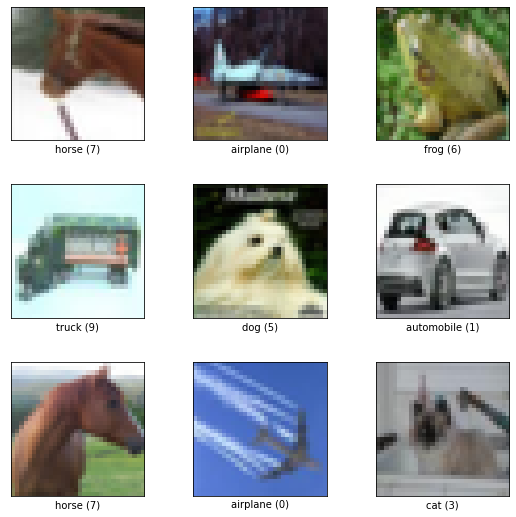

In [12]:
fig = tfds.show_examples(ds_test, ds_info)

### Flow

1. 입력데이터 정규화

2. 클래스 개수 파악

3. 클래스 종류 파아

4. 클래스 사진들 눈으로 보기


## Ablation Study 실습 

### 블록 구성하기

블록은 주요 구조를 모듈화 시켜 조금씩 바꿔 쓸 수 있는 단위를 말합니다

레이어는 기본적인 라이브러리등에서 제공하는 단위입니다.

ResNet을 한 방에 이해해서 바로 구현하면 좋지만 조금 더 간단한 VGG를 예시로 구현하겠습니다.

VGG블록은 CNN레이어(3X3) 여러 개 와 Max pooling레이어 한 개로 이뤄져있고 한 블록 내 레이어의 채널은 하나로 유지가 되기에 다른 CNN레이어의 채널 수와 다를 수 있습니다. 

그리고 CNN의 레이어 수와 채널을 조절하면서 만들어야합니다.


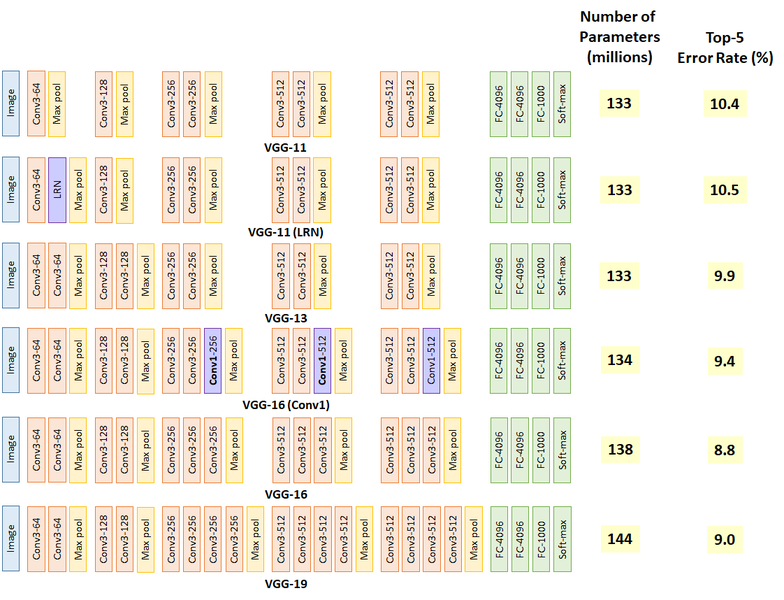

여러 VGG종류 중에서 16과 19 기본 구조 블록을 만들겠습니다.



In [13]:
# function for building VGG Block

def build_vgg_block(input_layer,
                    num_cnn=3, 
                    channel=64,
                    block_num=1,
                   ): #block_num은 레이어의 이름 붙여주기 
    # 입력 레이어
    x = input_layer

    # CNN 레이어
    for cnn_num in range(num_cnn):
        x = keras.layers.Conv2D(
            filters=channel,
            kernel_size=(3,3),
            activation='relu',
            kernel_initializer='he_normal',
            padding='same',
            name=f'block{block_num}_conv{cnn_num}'
        )(x)    

    # Max Pooling 레이어
    x = keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=2,
        name=f'block{block_num}_pooling'
    )(x)

    return x

In [14]:
vgg_input_layer = keras.layers.Input(shape=(32,32,3))   # 입력 레이어 생성
vgg_block_output = build_vgg_block(vgg_input_layer)    # VGG 블록 생성, 블록레이어를 build하고 출력값 얻음

In [15]:
# 블록 1개짜리 model 생성
model = keras.Model(inputs=vgg_input_layer, outputs=vgg_block_output)  
# 케라스의 Model클래스에서 I/O정의하면
model.summary() # 블록 모델 요약본 확인 가능

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 16, 16, 64)        0         
Total params: 75,648
Trainable params: 75,648
Non-trainable params: 0
_________________________________________________________________


### Flow

1. 함수로 VGG모델 만들기

2. Input_layer와 Output 지정

3. Summary

## Ablation Study 

###  VGG Complete Model

블록 내의 CNN 레이어 수와 채널 수는 블록마다 달라지고 함수로 전달이 되어야합니다. 각 블록은 CNN의 수와 채널을 리스트로 전달하겠습니다.

#### VGG 모델

In [16]:
# VGG 모델 자체를 생성하는 함수입니다.
def build_vgg(input_shape=(32,32,3),
              num_cnn_list=[2,2,3,3,3],
              channel_list=[64,128,256,512,512],
              num_classes=10):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_vgg_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i
        )
        
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc1')(output)
    output = keras.layers.Dense(4096, activation='relu', name='fc2')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

### VGG16

In [17]:
# 기본값을 그대로 사용해서 VGG 모델을 만들면 VGG-16이 됩니다.
vgg_16 = build_vgg()

vgg_16.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

### VGG-19

위의 16의 구성을 바꾸면 만들기가 쉬워집니다.

In [18]:
# 원하는 블록의 설계에 따라 매개변수로 리스트를 전달해 줍니다.
vgg_19 = build_vgg(
    num_cnn_list=[2,2,4,4,4],
    channel_list=[64,128,256,512,512]
)

vgg_19.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block0_conv0 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block0_conv1 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block0_pooling (MaxPooling2D (None, 16, 16, 64)        0         
_________________________________________________________________
block1_conv0 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block1_pooling (MaxPooling2D (None, 8, 8, 128)         0   

## Ablation Study 

### VGG-16 vs VGG-19

VGG의 레이어 차이를 비교하기 위해서 16과19를 비교하겠습니다.

In [19]:
# 파라미터 설정

BATCH_SIZE = 128
EPOCH = 20

In [20]:
# CIFAR10 데이터셋 부르기

(ds_train, ds_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

### VGG-16모델 훈련

In [21]:
vgg_16.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_16 = vgg_16.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
390/390 [==============================] - 108s 215ms/step - loss: 2.1971 - accuracy: 0.1740 - val_loss: 1.9726 - val_accuracy: 0.2942
Epoch 2/20
390/390 [==============================] - 56s 145ms/step - loss: 1.8869 - accuracy: 0.3163 - val_loss: 1.7330 - val_accuracy: 0.3777
Epoch 3/20
390/390 [==============================] - 57s 146ms/step - loss: 1.6878 - accuracy: 0.3883 - val_loss: 1.6276 - val_accuracy: 0.4267
Epoch 4/20
390/390 [==============================] - 57s 146ms/step - loss: 1.5757 - accuracy: 0.4342 - val_loss: 1.5174 - val_accuracy: 0.4565
Epoch 5/20
390/390 [==============================] - 57s 146ms/step - loss: 1.4994 - accuracy: 0.4616 - val_loss: 1.4792 - val_accuracy: 0.4739
Epoch 6/20
390/390 [==============================] - 57s 146ms/step - loss: 1.4246 - accuracy: 0.4859 - val_loss: 1.3669 - val_accuracy: 0.5091
Epoch 7/20
390/390 [==============================] - 57s 146ms/step - loss: 1.3660 - accuracy: 0.5102 - val_loss: 1.3054 - val_a

### VGG-19모델


In [22]:
vgg_19.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_19 = vgg_19.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['test'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
390/390 [==============================] - 73s 174ms/step - loss: 2.2553 - accuracy: 0.1399 - val_loss: 2.0030 - val_accuracy: 0.2662
Epoch 2/20
390/390 [==============================] - 68s 174ms/step - loss: 1.9509 - accuracy: 0.2866 - val_loss: 1.7555 - val_accuracy: 0.3505
Epoch 3/20
390/390 [==============================] - 68s 175ms/step - loss: 1.7379 - accuracy: 0.3653 - val_loss: 1.6246 - val_accuracy: 0.4120
Epoch 4/20
390/390 [==============================] - 68s 175ms/step - loss: 1.6156 - accuracy: 0.4147 - val_loss: 1.5050 - val_accuracy: 0.4500
Epoch 5/20
390/390 [==============================] - 68s 176ms/step - loss: 1.5145 - accuracy: 0.4506 - val_loss: 1.5101 - val_accuracy: 0.4470
Epoch 6/20
390/390 [==============================] - 69s 176ms/step - loss: 1.4458 - accuracy: 0.4717 - val_loss: 1.3618 - val_accuracy: 0.5055
Epoch 7/20
390/390 [==============================] - 69s 176ms/step - loss: 1.3621 - accuracy: 0.5053 - val_loss: 1.2903 - val_ac

### 그래프로 손실과 정확성을 비교해봅시다.

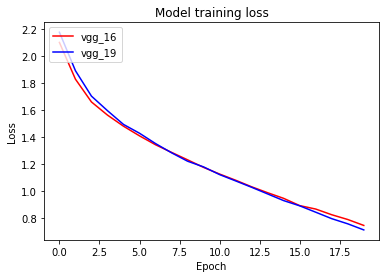

In [23]:
import matplotlib.pyplot as plt

plt.plot(history_16.history['loss'], 'r')
plt.plot(history_19.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()

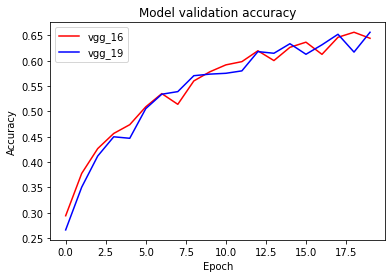

In [24]:
plt.plot(history_16.history['val_accuracy'], 'r')
plt.plot(history_19.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['vgg_16', 'vgg_19'], loc='upper left')
plt.show()